<a href="https://colab.research.google.com/github/muminjia/next-token-prediction/blob/main/Simulations_combine_two_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import copy
import itertools
from collections import defaultdict
import numpy as np
import numpy.linalg as npl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.svm import LinearSVC
import cvxpy as cp
from data_utils_m import *
from nxt_token_solver_m import W_svm_solver_cvxpy, R_solver, Tarjan

from base_nonlinear import MLayerAttn
from utils import *
from train_utils_m import train_W, train_Wfin
from visualizer import show_corr, show_norm_diff, show_proj_corr, show_attn_probs, show_attn_probs_neg

import time

In [2]:
starttime = time.time()

## Parameters

### Numeric Settings

In [3]:
K = 8  # Vocabulary size
L = 4  # Number of arrows to randomly choose
T = 4 # the length of sequence (not include the next token)
n = 100 # Number of sequence in each dataset
d = 8 # dim of embedding token

### Data Parameters

In [4]:
token_choice = 'random' # ['equi-corr', 'ortho', 'random']
cls_choice = 'iden'
same_last_token = False
rep_seq = False
check_label = True
check_asyc = False

toy_case = False
batch_toy = False
custom_initialize = False

separa = False # Whether the last token can map to different labels

### Attention Model Parameters


In [5]:
loss_type = 'nll' # ['ce', 'nll', 'corr', 'lsq2', 'mse']

nlayer = 1 # number of layers

skip = False # add skip connection to every attention output
layer_norm = False # add layer norm to every attention output
avg_norm = False
factorize_w = False # use W or (Q, K)

initialize_w = 'default' # 'default': random initialization, 'zero': initialize W as zero matrix, 'random': random initialization with varying variance
strong_default = False
initialize_wfin = 'zero'

reg_wfin = 0 # regularization for W_fin
# W_fin must be initialized as zero matrix

lr = 0.01

epochs = 1
ITN = 4000

norm_grad = True

Wi_list = np.zeros((nlayer, ITN, d, d))
sol_cvx_list = np.zeros((nlayer, d, d))
Wi_norm_list = np.zeros((nlayer, epochs, ITN))

dlist = [8]
attn_probs = np.zeros((len(dlist), epochs, ITN))
corr_list = np.zeros((len(dlist), 2, epochs, ITN))

In [6]:
def customize_seed(seed): # {topic 1: seed = 42, topic 2: seed = 99, combine: seed = 22}
    random.seed(seed) # select_arrows_for_each_token() and find_and_add_missing_relationships()
    np.random.seed(seed) # step 2.3 of generate_sequence_from_tpgs()
    torch.manual_seed(seed)

## Part 1: Generate TPGs

### Step 1. Define K and L

### Step 2. Randomly choose  𝐿  (# of arrows) couples for each token

In [7]:
# Get all possible directed edges (ei -> ej where ei != ej)
all_possible_edges = [(i, j) for i, j in itertools.permutations(range(K), 2)]

# Step 2: For each token k = 1, 2, ..., K, randomly select L arrows involving k
def select_arrows_for_each_token(K, L):
    all_tpgs = []
    for k in range(K):
        # Select edges where token k is involved (either as the source or destination)
        valid_edges = [edge for edge in all_possible_edges if edge[0] == k or edge[1] == k]

        # Ensure that token k is included in the TPG
        selected_edges = random.sample(valid_edges, 1)  # Pick one edge that includes token k

        # Now pick the rest of the L-1 arrows from all possible edges (can include or exclude token k)
        other_edges = [edge for edge in all_possible_edges if edge not in selected_edges]
        selected_edges += random.sample(other_edges, L - 1)  # Pick (L-1) arrows randomly

        all_tpgs.append(selected_edges)
    return all_tpgs

In [8]:
# For topic 1
customize_seed(42)
# Generate K groups with L arrows each
tpgs_1 = select_arrows_for_each_token(K, L)

# Display the results
print("Selected edges for each TPG:")
for idx, tpg in enumerate(tpgs_1, 0):
    print(f"TPG_1 for token {idx}: {tpg}")

Selected edges for each TPG:
TPG_1 for token 0: [(4, 0), (1, 0), (0, 2), (6, 7)]
TPG_1 for token 1: [(1, 4), (2, 3), (2, 1), (1, 2)]
TPG_1 for token 2: [(5, 2), (0, 7), (6, 2), (6, 7)]
TPG_1 for token 3: [(3, 6), (0, 6), (5, 3), (4, 0)]
TPG_1 for token 4: [(0, 4), (0, 2), (0, 7), (2, 0)]
TPG_1 for token 5: [(3, 5), (4, 6), (5, 4), (0, 2)]
TPG_1 for token 6: [(6, 2), (1, 6), (6, 4), (5, 7)]
TPG_1 for token 7: [(7, 4), (4, 7), (3, 6), (2, 0)]


In [9]:
# for topic 2
customize_seed(99)
# Generate K groups with L arrows each
tpgs_2 = select_arrows_for_each_token(K, L)

# Display the results
print("Selected edges for each TPG:")
for idx, tpg in enumerate(tpgs_2, 0):
    print(f"TPG_2 for token {idx}: {tpg}")

Selected edges for each TPG:
TPG_2 for token 0: [(0, 7), (3, 5), (1, 7), (5, 4)]
TPG_2 for token 1: [(1, 2), (2, 1), (2, 3), (1, 3)]
TPG_2 for token 2: [(6, 2), (0, 6), (2, 3), (6, 5)]
TPG_2 for token 3: [(3, 4), (4, 7), (6, 2), (6, 3)]
TPG_2 for token 4: [(4, 5), (0, 6), (5, 6), (4, 3)]
TPG_2 for token 5: [(3, 5), (3, 7), (6, 5), (5, 6)]
TPG_2 for token 6: [(6, 3), (1, 7), (7, 2), (3, 2)]
TPG_2 for token 7: [(7, 6), (3, 4), (6, 1), (1, 7)]


### Step 3. Check and add missing relationship between any two tokens

In [10]:
# Find if there is a direct or indirect path between any two tokens
def has_path(graph, start, end, visited):
    if start == end:
        return True
    visited.add(start)
    for neighbor in graph[start]:
        if neighbor not in visited and has_path(graph, neighbor, end, visited):
            return True
    return False

# Find missing relationships between any two tokens and add the arrow
def find_and_add_missing_relationships(tpg):


    # Build a directed graph from the selected edges
    graph = defaultdict(list)
    for edge in tpg:
        graph[edge[0]].append(edge[1])

    # Get the nodes in the current TPG
    nodes = set([edge[0] for edge in tpg] + [edge[1] for edge in tpg])

    # Check pairs of nodes that are missing direct or indirect connections
    for i, j in itertools.combinations(nodes, 2):
        # Check if there's a path from i to j or j to i
        if not has_path(graph, i, j, set()) and not has_path(graph, j, i, set()):
            # Randomly choose the direction to add the missing arrow
            if random.choice([True, False]):
                tpg.append((i, j))  # Add arrow i -> j
                graph[i].append(j)
            else:
                tpg.append((j, i))  # Add arrow j -> i
                graph[j].append(i)

    return tpg

### Step 4. Generate TPG_1 and TPG_2 for topic 1 and topic 2 respectively

In [11]:
def generate_tpg(tpgs):
    updated_tpgs=[] # updated tpg_1 for each token
    for tpg in tpgs:
        tpg_copy = copy.deepcopy(tpg)
        updated_tpg = find_and_add_missing_relationships(tpg_copy)
        updated_tpgs.append(updated_tpg)

    return updated_tpgs

In [12]:
# For topic 1
customize_seed(42)

updated_tpgs_1=[] # updated tpg_1 for each token
for tpg in tpgs_1:
    tpg_copy = copy.deepcopy(tpg)
    updated_tpg = find_and_add_missing_relationships(tpg_copy)
    updated_tpgs_1.append(updated_tpg)

for idx, (tpg, updated_tpg) in enumerate(zip(tpgs_1, updated_tpgs_1), 0):
    print(f"TPG_1 for token {idx}: {tpg}")
    print(f"Updated TPG_1 for token {idx}: {updated_tpg}\n")

TPG_1 for token 0: [(4, 0), (1, 0), (0, 2), (6, 7)]
Updated TPG_1 for token 0: [(4, 0), (1, 0), (0, 2), (6, 7), (0, 6), (1, 4), (6, 2), (2, 7)]

TPG_1 for token 1: [(1, 4), (2, 3), (2, 1), (1, 2)]
Updated TPG_1 for token 1: [(1, 4), (2, 3), (2, 1), (1, 2), (3, 4)]

TPG_1 for token 2: [(5, 2), (0, 7), (6, 2), (6, 7)]
Updated TPG_1 for token 2: [(5, 2), (0, 7), (6, 2), (6, 7), (0, 2), (0, 5), (0, 6), (7, 2), (5, 6)]

TPG_1 for token 3: [(3, 6), (0, 6), (5, 3), (4, 0)]
Updated TPG_1 for token 3: [(3, 6), (0, 6), (5, 3), (4, 0), (0, 3), (0, 5)]

TPG_1 for token 4: [(0, 4), (0, 2), (0, 7), (2, 0)]
Updated TPG_1 for token 4: [(0, 4), (0, 2), (0, 7), (2, 0), (4, 7)]

TPG_1 for token 5: [(3, 5), (4, 6), (5, 4), (0, 2)]
Updated TPG_1 for token 5: [(3, 5), (4, 6), (5, 4), (0, 2), (0, 3), (2, 3)]

TPG_1 for token 6: [(6, 2), (1, 6), (6, 4), (5, 7)]
Updated TPG_1 for token 6: [(6, 2), (1, 6), (6, 4), (5, 7), (1, 5), (4, 2), (2, 5)]

TPG_1 for token 7: [(7, 4), (4, 7), (3, 6), (2, 0)]
Updated TPG_1

In [13]:
# For topic 2
customize_seed(99)

updated_tpgs_2=[] # updated tpg_2 for each token
for tpg in tpgs_2:
    tpg_copy = copy.deepcopy(tpg)
    updated_tpg = find_and_add_missing_relationships(tpg_copy)
    updated_tpgs_2.append(updated_tpg)

for idx, (tpg, updated_tpg) in enumerate(zip(tpgs_2, updated_tpgs_2), 0):
    print(f"TPG_2 for token {idx}: {tpg}")
    print(f"Updated TPG_2 for token {idx}: {updated_tpg}\n")

TPG_2 for token 0: [(0, 7), (3, 5), (1, 7), (5, 4)]
Updated TPG_2 for token 0: [(0, 7), (3, 5), (1, 7), (5, 4), (1, 0), (3, 0), (0, 4), (0, 5), (1, 3), (4, 7)]

TPG_2 for token 1: [(1, 2), (2, 1), (2, 3), (1, 3)]
Updated TPG_2 for token 1: [(1, 2), (2, 1), (2, 3), (1, 3)]

TPG_2 for token 2: [(6, 2), (0, 6), (2, 3), (6, 5)]
Updated TPG_2 for token 2: [(6, 2), (0, 6), (2, 3), (6, 5), (2, 5), (3, 5)]

TPG_2 for token 3: [(3, 4), (4, 7), (6, 2), (6, 3)]
Updated TPG_2 for token 3: [(3, 4), (4, 7), (6, 2), (6, 3), (3, 2), (4, 2), (2, 7)]

TPG_2 for token 4: [(4, 5), (0, 6), (5, 6), (4, 3)]
Updated TPG_2 for token 4: [(4, 5), (0, 6), (5, 6), (4, 3), (3, 0), (0, 5)]

TPG_2 for token 5: [(3, 5), (3, 7), (6, 5), (5, 6)]
Updated TPG_2 for token 5: [(3, 5), (3, 7), (6, 5), (5, 6), (7, 5)]

TPG_2 for token 6: [(6, 3), (1, 7), (7, 2), (3, 2)]
Updated TPG_2 for token 6: [(6, 3), (1, 7), (7, 2), (3, 2), (1, 3), (6, 1), (7, 3)]

TPG_2 for token 7: [(7, 6), (3, 4), (6, 1), (1, 7)]
Updated TPG_2 for tok

### Step 5. Generate TPG combining two topics

In [14]:
# Combine two TPGs for each token
def combine_tpgs(tpgs_group_1, tpgs_group_2):
    combined_tpgs = []
    for tpg1, tpg2 in zip(tpgs_group_1, tpgs_group_2):
        combined_tpg = tpg1 + [edge for edge in tpg2 if edge not in tpg1]  # Combine unique edges
        combined_tpgs.append(combined_tpg)
    return combined_tpgs

# Check missing relationships for the combined TPG
def check_missing_relationships_in_combined_tpgs(combined_tpgs):
    for idx, tpg in enumerate(combined_tpgs, 1):
        print(f"Combined TPG for token {idx}: {tpg}")
        updated_tpg = find_and_add_missing_relationships(tpg)
        print(f"Combined TPG for token {idx} after adding missing arrows: {updated_tpg}\n")


In [15]:
customize_seed(22)

cb_tpgs = combine_tpgs(updated_tpgs_1, updated_tpgs_2) # combine TPGs for two topics
updated_cb_tpgs=[] # updated combine tpg for each token
for tpg in cb_tpgs:
    tpg_copy = copy.deepcopy(tpg)
    updated_tpg = find_and_add_missing_relationships(tpg_copy)
    updated_cb_tpgs.append(updated_tpg)

for idx, (tpg, updated_tpg) in enumerate(zip(cb_tpgs, updated_cb_tpgs), 0):
    print(f"Combined TPG for token {idx}: {tpg}")
    print(f"Updated Combined TPG for token {idx}: {updated_tpg}\n")

Combined TPG for token 0: [(4, 0), (1, 0), (0, 2), (6, 7), (0, 6), (1, 4), (6, 2), (2, 7), (0, 7), (3, 5), (1, 7), (5, 4), (3, 0), (0, 4), (0, 5), (1, 3), (4, 7)]
Updated Combined TPG for token 0: [(4, 0), (1, 0), (0, 2), (6, 7), (0, 6), (1, 4), (6, 2), (2, 7), (0, 7), (3, 5), (1, 7), (5, 4), (3, 0), (0, 4), (0, 5), (1, 3), (4, 7)]

Combined TPG for token 1: [(1, 4), (2, 3), (2, 1), (1, 2), (3, 4), (1, 3)]
Updated Combined TPG for token 1: [(1, 4), (2, 3), (2, 1), (1, 2), (3, 4), (1, 3)]

Combined TPG for token 2: [(5, 2), (0, 7), (6, 2), (6, 7), (0, 2), (0, 5), (0, 6), (7, 2), (5, 6), (2, 3), (6, 5), (2, 5), (3, 5)]
Updated Combined TPG for token 2: [(5, 2), (0, 7), (6, 2), (6, 7), (0, 2), (0, 5), (0, 6), (7, 2), (5, 6), (2, 3), (6, 5), (2, 5), (3, 5)]

Combined TPG for token 3: [(3, 6), (0, 6), (5, 3), (4, 0), (0, 3), (0, 5), (3, 4), (4, 7), (6, 2), (6, 3), (3, 2), (4, 2), (2, 7)]
Updated Combined TPG for token 3: [(3, 6), (0, 6), (5, 3), (4, 0), (0, 3), (0, 5), (3, 4), (4, 7), (6, 2

## Part 2: Generate data for each topic

### Step 6. Decide the length of sequence T

### Step 7. Generate sequence for each topic

In [16]:
def generate_sequence_from_tpgs(updated_tpgs_1, T):
    sequence_length = T  # Sequence length is T = 4

    # Step 1: Randomly choose the last token k (e_T)
    last_token_k = random.randint(0, K-1)  # Choose a random token as the last one (0 <= k <= K-1)

    tpg_for_k = updated_tpgs_1[last_token_k]  # Select the TPG for the last token k


    # Step 2: Randomly choose the next token e_{T+1} in the selected TPG
    ## 2.1 find e_j that have arrows coming from the last token k
    outgoing_edges = [edge for edge in tpg_for_k if edge[0] == last_token_k]
    destination_nodes = [edge[1] for edge in outgoing_edges]
    destination_nodes.append(last_token_k)

    ## 2.2 count the arrows pointing to each destination node (include e_j itself)
    destination_counts = {node: 1 for node in destination_nodes} # start from 1: including e_j itself
    for edge in tpg_for_k:
        if edge[1] in destination_counts:
            destination_counts[edge[1]] += 1

    ## 2.3 randomly choose the next token e_{T+1} based on weighted prob
    total_count = sum(destination_counts.values())
    prob = [count / total_count for count in destination_counts.values()]

    next_token = np.random.choice(list(destination_counts.keys()), p=prob)


    # Step 3: Randomly choose the location of the next token in the input sequence
    available_positions = list(range(sequence_length - 1))  # Positions: 0, 1, 2, 3
    next_token_position_input = random.choice(available_positions)  # Choose a position for e_{T+1}

    input_sequence = [None] * (sequence_length - 1) # Initialize the input sequence with None
    input_sequence.append(last_token_k)
    input_sequence[next_token_position_input] = next_token  # Place e_{T+1} in the sequence


    # Step 4: Randomly choose the rest of the tokens that have arrows to the next token in the TPG
    remaining_positions = [pos for pos in available_positions if pos != next_token_position_input]

    # Find tokens that have arrows pointing to the chosen next token
    possible_previous_tokens = [edge[0] for edge in tpg_for_k if edge[1] == next_token]
    possible_previous_tokens.append(next_token) # next_token can also be chosen as the rest of token

    if len(possible_previous_tokens) == 0:
        raise ValueError(f"No available nodes in the TPG for token {last_token_k}.")

    # Randomly choose tokens for the remaining positions
    for pos in remaining_positions:
        token = random.choice(possible_previous_tokens)
        input_sequence[pos] = token

    # check process if needed
    # print("\nlast_token:", last_token_k)
    # print("the selected tpg:", tpg_for_k)
    # print("destination_nodes:", destination_nodes)
    # print("destination_counts:", destination_counts)
    # print("next token:", next_token)
    # print("next_token randomly putted in:", next_token_position_input)
    # print("prob:", prob)
    # print("possible rest tokens:", possible_previous_tokens)

    return input_sequence, next_token

In [17]:
# Test
customize_seed(42)

generate_sequence_from_tpgs(updated_tpgs_1, T)

([4, 4, 3, 1], 4)

In [18]:
updated_tpgs_1

[[(4, 0), (1, 0), (0, 2), (6, 7), (0, 6), (1, 4), (6, 2), (2, 7)],
 [(1, 4), (2, 3), (2, 1), (1, 2), (3, 4)],
 [(5, 2), (0, 7), (6, 2), (6, 7), (0, 2), (0, 5), (0, 6), (7, 2), (5, 6)],
 [(3, 6), (0, 6), (5, 3), (4, 0), (0, 3), (0, 5)],
 [(0, 4), (0, 2), (0, 7), (2, 0), (4, 7)],
 [(3, 5), (4, 6), (5, 4), (0, 2), (0, 3), (2, 3)],
 [(6, 2), (1, 6), (6, 4), (5, 7), (1, 5), (4, 2), (2, 5)],
 [(7, 4), (4, 7), (3, 6), (2, 0), (3, 0), (4, 0), (0, 6), (2, 3), (4, 2)]]

### Step 8. Repeat $n$ times to generate data for topic 1

In [19]:
# Generate data set with N sequences based on the updated TPG
def generate_data(updated_tpgs, n):

    results = []
    for i in range(n):
        sequence, next_token = generate_sequence_from_tpgs(updated_tpgs, T)
        results.append((sequence, next_token))

    return results

In [20]:
customize_seed(42)

data_topic_1 = generate_data(updated_tpgs_1,n)
data_topic_1

[([4, 4, 3, 1], 4),
 ([3, 5, 3, 3], 3),
 ([2, 1, 1, 1], 1),
 ([6, 0, 0, 0], 6),
 ([6, 3, 6, 3], 6),
 ([6, 6, 6, 3], 6),
 ([2, 4, 2, 6], 2),
 ([4, 0, 4, 4], 4),
 ([3, 5, 3, 5], 5),
 ([5, 3, 5, 5], 5),
 ([3, 4, 4, 1], 4),
 ([4, 4, 0, 4], 4),
 ([6, 6, 6, 6], 6),
 ([3, 3, 6, 3], 6),
 ([3, 6, 3, 3], 6),
 ([3, 4, 3, 1], 4),
 ([4, 4, 4, 5], 4),
 ([0, 3, 3, 3], 3),
 ([1, 1, 2, 1], 2),
 ([7, 2, 0, 2], 2),
 ([0, 5, 3, 3], 3),
 ([6, 0, 0, 3], 6),
 ([7, 0, 7, 4], 7),
 ([4, 4, 4, 5], 4),
 ([4, 4, 7, 7], 4),
 ([3, 3, 3, 3], 3),
 ([7, 4, 7, 4], 7),
 ([6, 4, 6, 6], 4),
 ([7, 4, 4, 7], 7),
 ([6, 7, 2, 2], 2),
 ([2, 2, 2, 1], 2),
 ([0, 7, 7, 4], 7),
 ([4, 3, 4, 1], 4),
 ([5, 5, 5, 5], 5),
 ([5, 2, 0, 2], 2),
 ([5, 0, 2, 2], 2),
 ([6, 0, 3, 3], 6),
 ([6, 6, 2, 0], 2),
 ([0, 1, 1, 0], 0),
 ([6, 3, 6, 3], 6),
 ([4, 4, 3, 1], 4),
 ([1, 1, 2, 1], 2),
 ([7, 4, 4, 7], 4),
 ([6, 1, 6, 6], 6),
 ([2, 4, 2, 6], 2),
 ([7, 4, 7, 7], 7),
 ([6, 3, 0, 3], 6),
 ([0, 0, 6, 0], 6),
 ([6, 0, 0, 0], 6),
 ([4, 3, 1, 1], 4),


### Step 9. Generate data for topic 2

In [21]:
data_topic_2 = generate_data(updated_tpgs_2,n)

### Step 10. Get the dataset for combining two topics

In [22]:
data_combine = generate_data(updated_cb_tpgs,n)

## Part 3: Calculate $W^{svm}$ and $W(\tau)$

### Step 11. Calculate $W_1^{svm}, W_2^{svm}, W^{svm}$ by using $\{X^1_i, y^1_i\}_{i=1}^N$, $\{X^2_i, y^2_i\}_{i=1}^N$, and $\{X_i, y_i\}_{i=1}^N$

#### 11.1 Get vocabulary and dictonary

In [23]:
customize_seed(2)

X, Vocab, C, dict_token, idx_token = next_data(
            n = n, T=T, K=K, d=d,
            rep_seq = rep_seq, token_choice= token_choice,
            same_last_token = same_last_token,
            check_label = check_label, check_asyc = check_asyc)

Vocab # K*d

tensor([[-0.3501,  0.3083, -0.4387, -0.3733, -0.4100,  0.3928, -0.3557, -0.0400],
        [-0.5119,  0.1947, -0.3222, -0.1326,  0.5682, -0.4245, -0.1269, -0.2440],
        [-0.6485, -0.1973, -0.3649,  0.2266,  0.0129, -0.0214,  0.4583,  0.3813],
        [ 0.1309, -0.1407,  0.0364,  0.7797,  0.0396,  0.3158,  0.0890,  0.4946],
        [-0.3043,  0.7280, -0.1108, -0.1082, -0.5149, -0.0097, -0.0936, -0.2819],
        [ 0.4708,  0.1749, -0.4833, -0.3040, -0.3794, -0.3492, -0.3927, -0.0404],
        [-0.3035,  0.0940, -0.4776,  0.5508,  0.0133,  0.4721, -0.1761,  0.3369],
        [ 0.2726, -0.4334, -0.2103, -0.1589, -0.7135,  0.2807, -0.2793, -0.0504]],
       dtype=torch.float64)

In [24]:
dict_token

{0: tensor([-0.3501,  0.3083, -0.4387, -0.3733, -0.4100,  0.3928, -0.3557, -0.0400],
        dtype=torch.float64),
 1: tensor([-0.5119,  0.1947, -0.3222, -0.1326,  0.5682, -0.4245, -0.1269, -0.2440],
        dtype=torch.float64),
 2: tensor([-0.6485, -0.1973, -0.3649,  0.2266,  0.0129, -0.0214,  0.4583,  0.3813],
        dtype=torch.float64),
 3: tensor([ 0.1309, -0.1407,  0.0364,  0.7797,  0.0396,  0.3158,  0.0890,  0.4946],
        dtype=torch.float64),
 4: tensor([-0.3043,  0.7280, -0.1108, -0.1082, -0.5149, -0.0097, -0.0936, -0.2819],
        dtype=torch.float64),
 5: tensor([ 0.4708,  0.1749, -0.4833, -0.3040, -0.3794, -0.3492, -0.3927, -0.0404],
        dtype=torch.float64),
 6: tensor([-0.3035,  0.0940, -0.4776,  0.5508,  0.0133,  0.4721, -0.1761,  0.3369],
        dtype=torch.float64),
 7: tensor([ 0.2726, -0.4334, -0.2103, -0.1589, -0.7135,  0.2807, -0.2793, -0.0504],
        dtype=torch.float64)}

In [25]:
data_topic_1

[([4, 4, 3, 1], 4),
 ([3, 5, 3, 3], 3),
 ([2, 1, 1, 1], 1),
 ([6, 0, 0, 0], 6),
 ([6, 3, 6, 3], 6),
 ([6, 6, 6, 3], 6),
 ([2, 4, 2, 6], 2),
 ([4, 0, 4, 4], 4),
 ([3, 5, 3, 5], 5),
 ([5, 3, 5, 5], 5),
 ([3, 4, 4, 1], 4),
 ([4, 4, 0, 4], 4),
 ([6, 6, 6, 6], 6),
 ([3, 3, 6, 3], 6),
 ([3, 6, 3, 3], 6),
 ([3, 4, 3, 1], 4),
 ([4, 4, 4, 5], 4),
 ([0, 3, 3, 3], 3),
 ([1, 1, 2, 1], 2),
 ([7, 2, 0, 2], 2),
 ([0, 5, 3, 3], 3),
 ([6, 0, 0, 3], 6),
 ([7, 0, 7, 4], 7),
 ([4, 4, 4, 5], 4),
 ([4, 4, 7, 7], 4),
 ([3, 3, 3, 3], 3),
 ([7, 4, 7, 4], 7),
 ([6, 4, 6, 6], 4),
 ([7, 4, 4, 7], 7),
 ([6, 7, 2, 2], 2),
 ([2, 2, 2, 1], 2),
 ([0, 7, 7, 4], 7),
 ([4, 3, 4, 1], 4),
 ([5, 5, 5, 5], 5),
 ([5, 2, 0, 2], 2),
 ([5, 0, 2, 2], 2),
 ([6, 0, 3, 3], 6),
 ([6, 6, 2, 0], 2),
 ([0, 1, 1, 0], 0),
 ([6, 3, 6, 3], 6),
 ([4, 4, 3, 1], 4),
 ([1, 1, 2, 1], 2),
 ([7, 4, 4, 7], 4),
 ([6, 1, 6, 6], 6),
 ([2, 4, 2, 6], 2),
 ([7, 4, 7, 7], 7),
 ([6, 3, 0, 3], 6),
 ([0, 0, 6, 0], 6),
 ([6, 0, 0, 0], 6),
 ([4, 3, 1, 1], 4),


#### 11.2 Get other input parameters
- Part 1: X
- Part 2: idx_token
- Part 3: idx_z
- Part 4: C_alpha
- Part 5: scc_klst

In [26]:
# Part 1: X, embedding word for each sequence
def get_X(data):

      input_X = []

      for item in data:
          key_sequence = item[0]  # Extract the token ID in each sequence
          values = [dict_token[key].tolist() for key in key_sequence]  # Get the corresponding values from dict_token
          input_X.append(values)

      input_X = torch.tensor(input_X)
      X = input_X.double() #dtype: torch.float64
      return X

# Part 2: idx_token, token ID for each input sequence
def get_idx_token(data):

    data_input_idx = [item[0] for item in data] # extract id of input sequence
    idx_token = torch.tensor(data_input_idx) # change list to tensor

    return idx_token

# Part 3: idx_z, the last token ID for each sequence
def get_idx_z(data):
      idx_z = []

      for i in range(n):
          idx_zi = data[i][0][-1]
          idx_z.append(idx_zi)

      idx_z = torch.tensor(idx_z)
      return idx_z

# Part 4: C/C_alpha, the next token ID for each sequence
def get_C_alpha(data):
    C = []
    for i in range(n):
      C_i = data[i][-1]
      C.append(C_i)

    C_alpha = torch.tensor(C)

    return C_alpha

# Part 5: get scc_klst: scc for each TPG
def get_scc_klst (idx_z, idx_token, C_alpha):
    scc_klst = []

    for k in range(K):
        tarjan_solver = Tarjan(K)
        mask = idx_token[:, -1] == k
        cnt = torch.sum(mask).item()
        if cnt == 0:
            scc_klst.append([])
            continue

        tarjan_solver.initialize(idx_token[mask], C_alpha[mask])
        tarjan_solver.run()
        #tarjan_solver.output()
        scc_lst = tarjan_solver.get_scc()
        scc_klst.append(scc_lst)

    return scc_klst

# Part 6: z, the last token of each sequence
def get_z(data, toy_case, batch_toy):

    X = get_X(data)
    if toy_case and batch_toy:
        input_z = []
        for i in range(len(X)):
            zi = X[i][-1]
            input_z.append(zi)
        input_z = torch.stack(input_z)
        assert input_z.shape == (n, d)
    else:
        input_z = X[:, -1].unsqueeze(1) # [n, d]

    z = input_z.double() #dtype: torch.float64
    return z


In [27]:
# get adj_mat: one of the input parameters of W_svm_solver_cvxpy
def get_adjacency_matrix (token_choice, idx_token, C_alpha):
    if token_choice == 'equi-corr':
            adj_mat = np.zeros((K -1, K - 1, K -1)) # #of distinct last tokens, |ID|, |ID|
    else:
        adj_mat = np.zeros((K , K , K )) # #of distinct last tokens, |ID|, |ID|

    for i in range(len(idx_token)):
        for j in range(len(idx_token[i])):
            if C_alpha[i] == idx_token[i][j]:
                continue
            adj_mat[idx_token[i][-1], C_alpha[i], idx_token[i][j]] = 1

    return adj_mat

#### 11.3 Calculate $W^{svm}_1$, $W^{svm}_2$, and $W^{svm}$

In [28]:
def get_input_paras(data):

      X = get_X(data)
      idx_token = get_idx_token (data)
      z = get_z(data, toy_case, batch_toy)
      idx_z = get_idx_z(data)
      C_alpha = get_C_alpha(data)
      scc_klst = get_scc_klst(idx_z, idx_token, C_alpha)
      adj_mat = get_adjacency_matrix (token_choice = token_choice, idx_token = idx_token, C_alpha = C_alpha)

      return X, idx_token, z, idx_z, C_alpha, scc_klst, adj_mat


In [29]:
def W_svm (data):



      w_dir = W_svm_solver_cvxpy(Vocab, n, d, idx_z, idx_token, C_alpha, onetoken = False, wfin = False, adj_mat = adj_mat, scc_lst = scc_klst)

      sol_cvx_list = np.zeros((nlayer, d, d))
      sol_cvx_list[0] =  normalize_sol(w_dir) # normalized w_dir


      return w_dir, sol_cvx_list


### Step 12. Generate $W_1(\tau)$, $W_2(\tau)$, $W(\tau)$, where $\tau = 1, ...., ITN$

#### Step 12.1: self-attention model

In [30]:
model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                        identity_W=False, identity_V = True,
                        factorize_W = factorize_w, init = initialize_w,
                        skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                ).double()

#### Step 12.2: $W$ training - train_W()

In [31]:
# Required input parameters for training
def get_para_list (factorize_w, layer_norm, avg_norm):

      if factorize_w:
            parameter_list = [model.query1.weight, model.query2.weight, model.key1.weight, model.key2.weight]
      else:
          parameter_list = [m.weight for m in model.qklist]

      if layer_norm and not avg_norm:
          parameter_list += [model.ln.weight, model.ln.bias]

      return parameter_list

parameter_list = get_para_list(factorize_w, layer_norm, avg_norm)
optimizer = torch.optim.SGD(parameter_list, lr=lr, )

In [32]:
def train_W_specific(data):

    # step 1. get required parpameters based on the specific data
    X = get_X(data)
    z = get_z(data, toy_case, batch_toy)
    idx_z = get_idx_z(data)
    idx_token = get_idx_token(data)
    C_alpha = get_C_alpha(data)
    scc_klst = get_scc_klst(idx_z, idx_token, C_alpha)

    # step 2. initialize Wi_list and attn_probs

    Wi_list = np.zeros((nlayer, ITN, d, d))
    Wi_norm_list = np.zeros((nlayer, epochs, ITN))
    attn_probs = np.zeros((len(dlist), epochs, ITN))

    # step 3. train W
    model_w= train_W(model, X, idx_token, z, token_choice, cls_choice, Vocab, C_alpha, nlayer, n, K, di, ei, ITN, toy_case, batch_toy, scc_klst,
        loss_type, optimizer, norm_grad, parameter_list,
        Wi_list = Wi_list, attn_probs = attn_probs, Wi_norm_list = Wi_norm_list,
    )


In [33]:
di = len(dlist)-1
ei = 0
train_W_specific(data_topic_1)

Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 0.7200
Current iteration: 500, Loss: 0.3354
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1000, Loss: 0.2185
Current iteration: 1500, Loss: 0.1612
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2000, Loss: 0.1311
Current iteration: 2500, Loss: 0.1159
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 3000, Loss: 0.1084
Current iteration: 3500, Loss: 0.1047


### Step 13. Correlation coefficient between $W^{svm}$ and $W(\tau)$

#### 13.1 Get correlation coefficient


In [34]:
epochs = 1

In [35]:
# initialize before running for loop "epochs"
datasets = ['data_topic_1', 'data_topic_2', 'data_combine']
attn_probs_values = {}
corr_list_values = {}
Wi_norm_list_values = {}
last_W_tau = {}
data_epochs = {}
dict_token_epochs = {}
X_epochs = {}
z_epochs = {}
last_W_epochs = {}
sol_cvx_list_epochs = {}
scc_klst_epochs = {}
updated_tpgs_epochs = {}

for data in datasets:
      attn_probs_values[data] = np.zeros((len(dlist), epochs, ITN))
      corr_list_values[data] = np.zeros((len(dlist), 2, epochs, ITN))
      Wi_norm_list_values[data] = np.zeros((nlayer, epochs, ITN))


In [36]:
for ei in range(epochs):
      print("\n********************************************")
      print("Current epoch:", ei)

      # Part 1: generate TPG for topic 1, topic 2, and combination

      tpgs_1 = select_arrows_for_each_token(K, L)
      updated_tpgs_1 = generate_tpg(tpgs_1) # TPG_1


      tpgs_2 = select_arrows_for_each_token(K, L)
      updated_tpgs_2 = generate_tpg(tpgs_2) #TPG_2


      cb_tpgs = combine_tpgs(updated_tpgs_1, updated_tpgs_2)
      updated_cb_tpgs = generate_tpg(cb_tpgs) # TPG_combine

      updated_tpgs_epochs[ei] = {'topic_1': updated_tpgs_1,
                                 'topic_2': updated_tpgs_2,
                                 'combine': updated_cb_tpgs}



      # Part 2: generate data and get input paras for topic 1, topic 2, and combination
      ## 2.1 get vocabulary and dict_token
      X_rm, Vocab, C_rm, dict_token, idx_token_rm = next_data( # Vocab and dict_token are required
              n = n, T=T, K=K, d=d,
              rep_seq = rep_seq, token_choice= token_choice,
              same_last_token = same_last_token,
              check_label = check_label, check_asyc = check_asyc)

      dict_token_epochs[ei] = dict_token

      ## 2.2 generate data
      data_topic_1 = generate_data(updated_tpgs_1, n) # data for topic 1
      data_topic_2 = generate_data(updated_tpgs_2, n) # data for topic 2
      data_combine = generate_data(updated_cb_tpgs, n) # data for combination

      data_epochs[ei] = {
          'topic_1': data_topic_1,
          'topic_2': data_topic_2,
          'combine': data_combine
      }

      # Part 3: Calculate W^{svm} and W(\tau) for each data

      datasets = ['data_topic_1', 'data_topic_2', 'data_combine']
      ## 3.1 input parameters needed
      # Create dictionaries to store the returned values
      X_values = {}
      idx_token_values = {}
      z_values = {}
      idx_z_values = {}
      C_alpha_values = {}
      scc_klst_values = {}
      adj_mat_values = {}
      w_dir_values = {}
      sol_cvx_list_values = {}
      Wi_list_values = {}
      last_W_tau = {}

      for data in datasets:
            X, idx_token, z, idx_z, C_alpha, scc_klst, adj_mat = get_input_paras(eval(data))

            X_values[data] = X
            idx_token_values[data] = idx_token
            z_values[data] = z
            idx_z_values[data] = idx_z
            C_alpha_values[data] = C_alpha
            scc_klst_values[data] = scc_klst
            adj_mat_values[data] = adj_mat

            ## 3.1 get W^{svm} for each data (w_dir_values[data] and sol_cvx_list_values[data][0])
            w_dir_values[data] = W_svm_solver_cvxpy(Vocab, n, d, idx_z_values[data], idx_token_values[data],
                                                    C_alpha_values[data], onetoken = False, wfin = False,
                                                    adj_mat = adj_mat_values[data], scc_lst = scc_klst_values[data])

            sol_cvx_list_values[data] = np.zeros((nlayer, d, d))
            sol_cvx_list_values[data][0] =  normalize_sol(w_dir_values[data]) # normalized w_dir

            ## 3.2 calculate W(\tau)
            model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                      identity_W=False, identity_V = True,
                      factorize_W = factorize_w, init = initialize_w,
                      skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
              ).double()

            parameter_list = get_para_list(factorize_w, layer_norm, avg_norm) # general_para_1
            optimizer = torch.optim.SGD(parameter_list, lr=lr, ) # general_para_2

            Wi_list_values[data] = np.zeros((nlayer, ITN, d, d)) # initialize Wi_list before training
            model = train_W(model, X_values[data], idx_token_values[data], z_values[data], token_choice, cls_choice, Vocab,
                            C_alpha_values[data], nlayer, n, K, di, ei, ITN, toy_case, batch_toy, scc_klst,
                            loss_type, optimizer, norm_grad, parameter_list,
                            Wi_list = Wi_list_values[data], attn_probs = attn_probs_values[data], Wi_norm_list = Wi_norm_list_values[data],
                          )
            ## 3.3 get correlation between W^{svm} and each W(\tau) (\tau = 1, 2, ..., ITN)
            for it in range(ITN):
                      Wi_list_values[data][0, it] /= np.linalg.norm(Wi_list_values[data][0, it])
                      if not separa:
                            corr_list_values[data][di, 0, ei, it] = Wi_list_values[data][0, it].reshape(-1).dot(sol_cvx_list_values[data][di].reshape(-1))
                            # NOTE: the source code is sol_cvx_list[di]!

            last_W_tau[data] = Wi_list_values[data][0, ITN-1]

            print("For", data, "correlation of W and Wsvm: ", corr_list_values[data][di, 0, ei, -1])
            print("----------------------------")

      last_W_epochs[ei] = last_W_tau
      X_epochs[ei] = X_values
      z_epochs[ei] = z_values
      sol_cvx_list_epochs[ei] = sol_cvx_list_values
      scc_klst_epochs[ei] = scc_klst_values



********************************************
Current epoch: 0
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 0.7704
Current iteration: 500, Loss: 0.2493
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1000, Loss: 0.1229
Current iteration: 1500, Loss: 0.0662
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2000, Loss: 0.0360
Current iteration: 2500, Loss: 0.0194
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 3000, Loss: 0.0105
Current iteration: 3500, Loss: 0.0056
For data_topic_1 correlation of W and Wsvm:  0.971273631848978
----------------------------
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 0.7285
Current iteration: 500, Loss: 0.2185
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1000, Loss: 0.0675
Current iteration: 1500, Loss: 0.0208
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2000, Loss: 0.0066
Cu

####13.2 Visualize Correlation Coefficient and Iteration



 For data_topic_1 :
Only shows Wmm


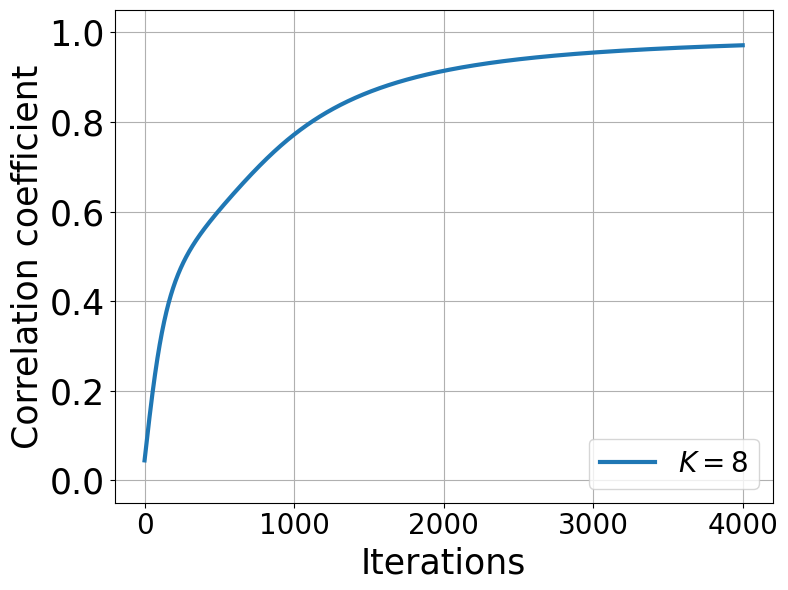



 For data_topic_2 :
Only shows Wmm


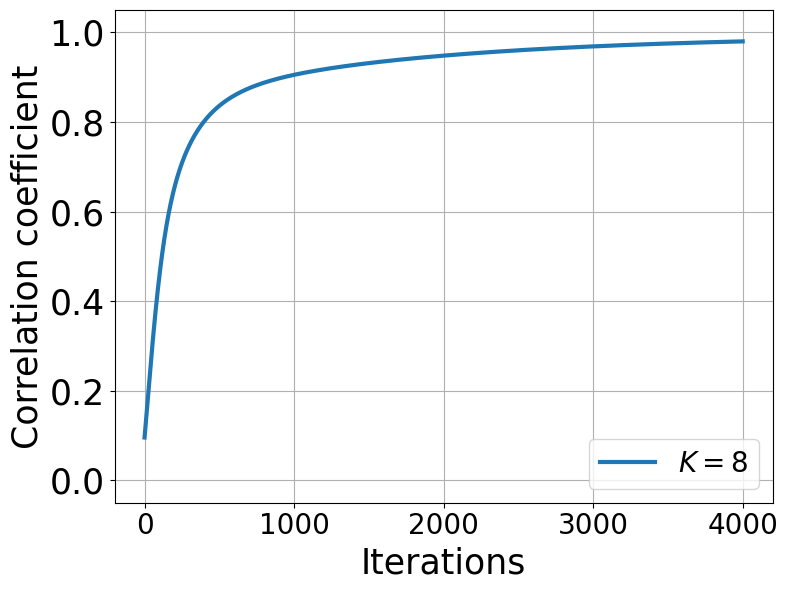



 For data_combine :
Only shows Wmm


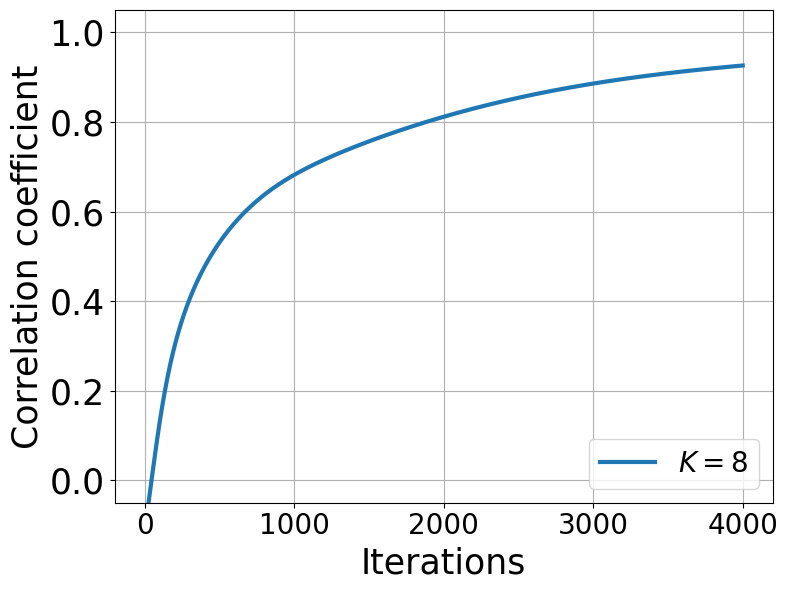

In [37]:
labels = [
    # r'$W(t)^{onetoken}$',
    r'$W(\tau)^{mm}$',
    r'$W(\tau)$',
]

for data in datasets:
    print('\n\n For', data, ':')
    show_corr(ITN, dlist, corr_list_values[data], wmm = True, labels = labels)

# Part 4: Generate the next tokens and check the similarity next token generated by the combined topics and the only one topic

### Step 14. Generate next token for input sequence from Topic 1

In [38]:
def generate_next_token(ei_test, topic, W_test):

      y_hat_idx = []
      y_hat = []
      softmax_output_n = []
      XWz_n = []

      for i in range(n):

          X_i = torch.tensor(X_epochs[ei_test][topic][i])
          z_test_i= z_epochs[ei_test][topic][i]
          z_i_transpose = z_test_i.T
          XWz = torch.matmul(X_i, torch.matmul(W_test, z_i_transpose))
          XWz_n.append(XWz)

          softmax_output = F.softmax(XWz, dim = 0)
          softmax_output_n.append(softmax_output)

          X_i_transpose = X_i.T
          f_Xi = torch.matmul(X_i_transpose, softmax_output) # embedding of the next token, shape (d, 1)
          f_Xi /= np.linalg.norm(f_Xi) # normalized embedding of the next token

          max_value = -float('inf')  # Initialize maximum value
          y_hat_i = None
          y_hat_i_eb = None

          for k in range(K):
              e_i = dict_token_epochs[ei_test][k] # shape (d)
              e_i_2d = e_i.unsqueeze(0) # shape (1, d)
              e_i_2d /= np.linalg.norm(e_i_2d)

              dot_prod = e_i_2d @ f_Xi

              if dot_prod > max_value:
                  max_value = dot_prod
                  y_hat_i = k
                  y_hat_i_eb = dict_token_epochs[ei_test][k]

          y_hat_idx.append(y_hat_i)
          y_hat.append(y_hat_i_eb)


      return y_hat_idx, y_hat, softmax_output_n, XWz_n

In [39]:
# Randomly choose one epoch's data from all epochs for test
ei_test = random.choice(range(epochs))
ei_test

0

In [40]:
# Extract W^{svm}, W_1(\tau), W_2(\tau), W_cb(\tau) of the selected epoch
W_svm_test = torch.tensor(sol_cvx_list_epochs[ei_test]['data_topic_1'][0])

W_1_test = torch.tensor(last_W_epochs[ei_test]['data_topic_1'])
W_2_test = torch.tensor(last_W_epochs[ei_test]['data_topic_2'])
W_cb_test = torch.tensor(last_W_epochs[ei_test]['data_combine'])

#### Using $W_1^{svm}$

In [41]:
y_hat_idx_svm, y_hat_svm, softmax_svm, XWz_n_svm = generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_svm_test)
y_hat_idx_svm

<ipython-input-38-fa3973bad719>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_i = torch.tensor(X_epochs[ei_test][topic][i])


[7,
 4,
 0,
 0,
 2,
 5,
 4,
 0,
 1,
 6,
 1,
 3,
 6,
 0,
 1,
 3,
 3,
 3,
 0,
 4,
 4,
 1,
 0,
 1,
 6,
 3,
 4,
 1,
 4,
 3,
 6,
 0,
 6,
 7,
 6,
 4,
 7,
 6,
 5,
 5,
 5,
 5,
 7,
 0,
 6,
 1,
 0,
 7,
 5,
 1,
 7,
 4,
 1,
 2,
 2,
 7,
 6,
 1,
 7,
 2,
 7,
 4,
 4,
 0,
 1,
 6,
 7,
 4,
 3,
 6,
 6,
 7,
 7,
 6,
 1,
 7,
 1,
 6,
 2,
 3,
 1,
 7,
 0,
 3,
 6,
 5,
 4,
 7,
 7,
 4,
 3,
 5,
 2,
 1,
 4,
 1,
 7,
 3,
 7,
 5]

#### Using $W_1{(\tau)}$ , where $\tau=\text{ITN}$

In [42]:
y_hat_idx_W1, y_hat_W1, softmax_W1, XWz_n_W1= generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_1_test)

<ipython-input-38-fa3973bad719>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_i = torch.tensor(X_epochs[ei_test][topic][i])


#### Using $W_2{(\tau)}$, where $\tau=\text{ITN}$

In [43]:
y_hat_idx_W2, y_hat_W2, softmax_W2, XWz_n_W2 = generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_2_test)


<ipython-input-38-fa3973bad719>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_i = torch.tensor(X_epochs[ei_test][topic][i])


#### Using $W_{cb}{(\tau)}$, where $\tau=\text{ITN}$

In [44]:
y_hat_idx_Wcb, y_hat_Wcb, softmax_Wcb, XWz_n_Wcb = generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_cb_test)

<ipython-input-38-fa3973bad719>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_i = torch.tensor(X_epochs[ei_test][topic][i])


## Step 15. Compare the similarity of the next token generated by different $W$

### Results from token_choice = 'random'

In [45]:
# check different prediction from topic 1 and topic combination
diff_t1_cb = 0 # count # of diff next tokens
diff_seqs = [] # save the sequence ID in the input data
diff_seqs_last = set() # save the last token ID the difference comes from

for i in range(n):

    if y_hat_idx_W1[i] != y_hat_idx_Wcb[i]:
        diff_t1_cb+=1
        diff_seqs.append(i)
        print('==============================================================================')
        print("For", i, "sequence:")
        print("next token from W1:", y_hat_idx_W1[i])
        print("next token from W2:", y_hat_idx_W2[i])
        print("next token from Wcb", y_hat_idx_Wcb[i])
        seq = data_epochs[ei_test]['topic_1'][i]
        print("sequence:", seq)
        last_token = data_epochs[ei_test]['topic_1'][i][0][-1]
        diff_seqs_last.add(last_token)
        print("\n************** Topic 1 **************")
        print("scc_lst for the token", last_token, ":", scc_klst_epochs[ei_test]['data_topic_1'][last_token] )
        print("tpg for the last token", last_token, ":", updated_tpgs_epochs[ei_test]['topic_1'][last_token])
        print("softmax output:", softmax_W1[i])
        print("softmax input:", XWz_n_W1[i])
        print("\n************** Topic 2 **************")
        print("scc_lst for the token", last_token,  ":", scc_klst_epochs[ei_test]['data_topic_2'][last_token] )
        print("tpg for the last token", last_token, ":", updated_tpgs_epochs[ei_test]['topic_2'][last_token])
        print("softmax output:", softmax_W2[i])
        print("softmax input:", XWz_n_W2[i])
        print("\n************** Topic Combination **************")
        print("scc_lst for the token", last_token,  ":", scc_klst_epochs[ei_test]['data_combine'][last_token] )
        print("tpg for the last token", last_token, ":", updated_tpgs_epochs[ei_test]['combine'][last_token])
        print("softmax output:", softmax_Wcb[i])
        print("softmax input:", XWz_n_Wcb[i])
print("Number of different next tokens from Topic 1 and Combine:", diff_t1_cb, "out of", n)

For 34 sequence:
next token from W1: 6
next token from W2: 6
next token from Wcb 0
sequence: ([7, 6, 4, 0], 6)

************** Topic 1 **************
scc_lst for the token 0 : [0, 1, 2, 3, 4, 5, 7, 6]
tpg for the last token 0 : [(7, 0), (7, 6), (0, 4), (0, 6), (4, 6)]
softmax output: tensor([[0.2525],
        [0.3046],
        [0.2630],
        [0.1800]], dtype=torch.float64)
softmax input: tensor([[-0.0503],
        [ 0.1371],
        [-0.0097],
        [-0.3890]], dtype=torch.float64)

************** Topic 2 **************
scc_lst for the token 0 : [0, 1, 2, 3, 4, 6, 7, 5]
tpg for the last token 0 : [(0, 6), (7, 4), (6, 3), (7, 5), (4, 0), (0, 5), (3, 5)]
softmax output: tensor([[0.2000],
        [0.3369],
        [0.2322],
        [0.2310]], dtype=torch.float64)
softmax input: tensor([[-0.2222],
        [ 0.2994],
        [-0.0725],
        [-0.0780]], dtype=torch.float64)

************** Topic Combination **************
scc_lst for the token 0 : [1, 2, 3, 4, 1, 5, 6, 0]
tpg for the

#### Check Results

In [47]:
diff_seqs_last

{0, 2}

In [51]:
# Reproduce the TPG based on the last token from diff_seqs_last
input_1 = data_epochs[ei_test]['topic_1']
input_2 = data_epochs[ei_test]['topic_2']
input_combine = data_epochs[ei_test]['combine']
for item in diff_seqs_last:
  extract_input_1 = [seq for seq in input_1 if seq[0][-1] == item]
  extract_input_2 = [seq for seq in input_2 if seq[0][-1] == item]
  extract_input_combine = [seq for seq in input_combine if seq[0][-1] == item]
  print("\n================================================================\n")
  print(f"Seqences with the last token {item}:")
  print("extracted_input_topic_1:", extract_input_1)
  print("extracted_input_topic_2:", extract_input_2)
  print("extracted_input_topic_combine:", extract_input_combine)
  print("scc_topic_1:", scc_klst_epochs[ei_test]['data_topic_1'][item])
  print("scc_topic_2:", scc_klst_epochs[ei_test]['data_topic_2'][item])
  print("scc_topic_combine:", scc_klst_epochs[ei_test]['data_combine'][item])
  print("tpgs_topic_1:", updated_tpgs_epochs[ei_test]['topic_1'][item])
  print("tpgs_topic_2:", updated_tpgs_epochs[ei_test]['topic_2'][item])
  print("tpgs_topic_combine:", updated_tpgs_epochs[ei_test]['combine'][item])



Seqences with the last token 0:
extracted_input_topic_1: [([6, 7, 7, 0], 6), ([4, 0, 4, 0], 4), ([7, 6, 0, 0], 6), ([4, 4, 0, 0], 4), ([0, 6, 6, 0], 6), ([7, 6, 0, 0], 6), ([4, 0, 4, 0], 4), ([6, 0, 7, 0], 6), ([0, 4, 4, 0], 4), ([0, 4, 4, 0], 4), ([6, 7, 6, 0], 6), ([7, 6, 6, 0], 6), ([7, 6, 4, 0], 6), ([4, 4, 4, 0], 4), ([0, 4, 4, 0], 4), ([4, 0, 4, 0], 4)]
extracted_input_topic_2: [([6, 6, 6, 0], 6), ([5, 5, 0, 0], 5), ([0, 6, 6, 0], 6), ([6, 0, 0, 0], 6), ([6, 6, 6, 0], 6), ([7, 7, 5, 0], 5), ([5, 5, 5, 0], 5), ([5, 0, 0, 0], 5), ([6, 6, 6, 0], 6), ([5, 5, 7, 0], 5)]
extracted_input_topic_combine: [([5, 0, 0, 0], 5), ([5, 5, 5, 0], 5), ([4, 0, 7, 0], 0), ([7, 5, 0, 0], 5), ([0, 0, 0, 0], 0), ([7, 5, 3, 0], 5), ([4, 6, 6, 0], 6), ([0, 7, 5, 0], 5), ([5, 5, 5, 0], 5), ([5, 0, 3, 0], 5), ([7, 6, 6, 0], 6), ([0, 4, 4, 0], 4), ([6, 6, 7, 0], 6)]
scc_topic_1: [0, 1, 2, 3, 4, 5, 7, 6]
scc_topic_2: [0, 1, 2, 3, 4, 6, 7, 5]
scc_topic_combine: [1, 2, 3, 4, 1, 5, 6, 0]
tpgs_topic_1: [(7, 0)

## Re-run whole process with token_choice = 'ortho'

In [53]:
epochs = 1
token_choice = 'ortho'

In [54]:
# initialize before running for loop "epochs"
datasets = ['data_topic_1', 'data_topic_2', 'data_combine']
attn_probs_values = {}
corr_list_values = {}
Wi_norm_list_values = {}
last_W_tau = {}
data_epochs = {}
dict_token_epochs = {}
X_epochs = {}
z_epochs = {}
last_W_epochs = {}
sol_cvx_list_epochs = {}
scc_klst_epochs = {}
updated_tpgs_epochs = {}

for data in datasets:
      attn_probs_values[data] = np.zeros((len(dlist), epochs, ITN))
      corr_list_values[data] = np.zeros((len(dlist), 2, epochs, ITN))
      Wi_norm_list_values[data] = np.zeros((nlayer, epochs, ITN))

In [55]:
for ei in range(epochs):
      print("\n********************************************")
      print("Current epoch:", ei)

      # Part 1: generate TPG for topic 1, topic 2, and combination

      tpgs_1 = select_arrows_for_each_token(K, L)
      updated_tpgs_1 = generate_tpg(tpgs_1) # TPG_1


      tpgs_2 = select_arrows_for_each_token(K, L)
      updated_tpgs_2 = generate_tpg(tpgs_2) #TPG_2


      cb_tpgs = combine_tpgs(updated_tpgs_1, updated_tpgs_2)
      updated_cb_tpgs = generate_tpg(cb_tpgs) # TPG_combine

      updated_tpgs_epochs[ei] = {'topic_1': updated_tpgs_1,
                                 'topic_2': updated_tpgs_2,
                                 'combine': updated_cb_tpgs}



      # Part 2: generate data and get input paras for topic 1, topic 2, and combination
      ## 2.1 get vocabulary and dict_token
      X_rm, Vocab, C_rm, dict_token, idx_token_rm = next_data( # Vocab and dict_token are required
              n = n, T=T, K=K, d=d,
              rep_seq = rep_seq, token_choice= token_choice,
              same_last_token = same_last_token,
              check_label = check_label, check_asyc = check_asyc)

      dict_token_epochs[ei] = dict_token

      ## 2.2 generate data
      data_topic_1 = generate_data(updated_tpgs_1, n) # data for topic 1
      data_topic_2 = generate_data(updated_tpgs_2, n) # data for topic 2
      data_combine = generate_data(updated_cb_tpgs, n) # data for combination

      data_epochs[ei] = {
          'topic_1': data_topic_1,
          'topic_2': data_topic_2,
          'combine': data_combine
      }

      # Part 3: Calculate W^{svm} and W(\tau) for each data

      datasets = ['data_topic_1', 'data_topic_2', 'data_combine']
      ## 3.1 input parameters needed
      # Create dictionaries to store the returned values
      X_values = {}
      idx_token_values = {}
      z_values = {}
      idx_z_values = {}
      C_alpha_values = {}
      scc_klst_values = {}
      adj_mat_values = {}
      w_dir_values = {}
      sol_cvx_list_values = {}
      Wi_list_values = {}
      last_W_tau = {}

      for data in datasets:
            X, idx_token, z, idx_z, C_alpha, scc_klst, adj_mat = get_input_paras(eval(data))

            X_values[data] = X
            idx_token_values[data] = idx_token
            z_values[data] = z
            idx_z_values[data] = idx_z
            C_alpha_values[data] = C_alpha
            scc_klst_values[data] = scc_klst
            adj_mat_values[data] = adj_mat

            ## 3.1 get W^{svm} for each data (w_dir_values[data] and sol_cvx_list_values[data][0])
            w_dir_values[data] = W_svm_solver_cvxpy(Vocab, n, d, idx_z_values[data], idx_token_values[data],
                                                    C_alpha_values[data], onetoken = False, wfin = False,
                                                    adj_mat = adj_mat_values[data], scc_lst = scc_klst_values[data])

            sol_cvx_list_values[data] = np.zeros((nlayer, d, d))
            sol_cvx_list_values[data][0] =  normalize_sol(w_dir_values[data]) # normalized w_dir

            ## 3.2 calculate W(\tau)
            model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                      identity_W=False, identity_V = True,
                      factorize_W = factorize_w, init = initialize_w,
                      skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
              ).double()

            parameter_list = get_para_list(factorize_w, layer_norm, avg_norm) # general_para_1
            optimizer = torch.optim.SGD(parameter_list, lr=lr, ) # general_para_2

            Wi_list_values[data] = np.zeros((nlayer, ITN, d, d)) # initialize Wi_list before training
            model = train_W(model, X_values[data], idx_token_values[data], z_values[data], token_choice, cls_choice, Vocab,
                            C_alpha_values[data], nlayer, n, K, di, ei, ITN, toy_case, batch_toy, scc_klst,
                            loss_type, optimizer, norm_grad, parameter_list,
                            Wi_list = Wi_list_values[data], attn_probs = attn_probs_values[data], Wi_norm_list = Wi_norm_list_values[data],
                          )
            ## 3.3 get correlation between W^{svm} and each W(\tau) (\tau = 1, 2, ..., ITN)
            for it in range(ITN):
                      Wi_list_values[data][0, it] /= np.linalg.norm(Wi_list_values[data][0, it])
                      if not separa:
                            corr_list_values[data][di, 0, ei, it] = Wi_list_values[data][0, it].reshape(-1).dot(sol_cvx_list_values[data][di].reshape(-1))
                            # NOTE: the source code is sol_cvx_list[di]!

            last_W_tau[data] = Wi_list_values[data][0, ITN-1]

            print("For", data, "correlation of W and Wsvm: ", corr_list_values[data][di, 0, ei, -1])
            print("----------------------------")

      last_W_epochs[ei] = last_W_tau
      X_epochs[ei] = X_values
      z_epochs[ei] = z_values
      sol_cvx_list_epochs[ei] = sol_cvx_list_values
      scc_klst_epochs[ei] = scc_klst_values


********************************************
Current epoch: 0
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 0.8488
Current iteration: 500, Loss: 0.2518
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1000, Loss: 0.0895
Current iteration: 1500, Loss: 0.0324
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2000, Loss: 0.0117
Current iteration: 2500, Loss: 0.0042
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 3000, Loss: 0.0015
Current iteration: 3500, Loss: 0.0006
For data_topic_1 correlation of W and Wsvm:  0.9892327752526906
----------------------------
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 0, Loss: 0.7354
Current iteration: 500, Loss: 0.2626
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 1000, Loss: 0.1032
Current iteration: 1500, Loss: 0.0413
Norm of grad:  tensor(1.0000, dtype=torch.float64)
Current iteration: 2000, Loss: 0.0163
C



 For data_topic_1 :
Only shows Wmm


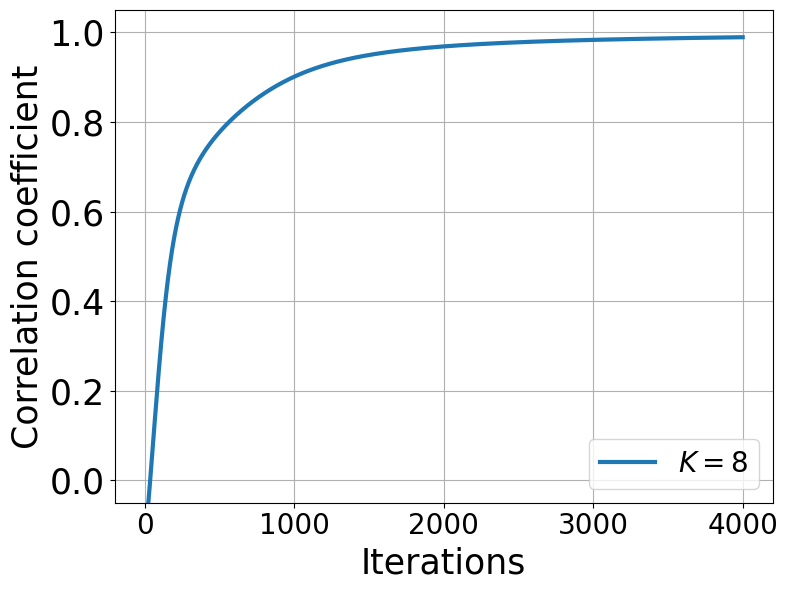



 For data_topic_2 :
Only shows Wmm


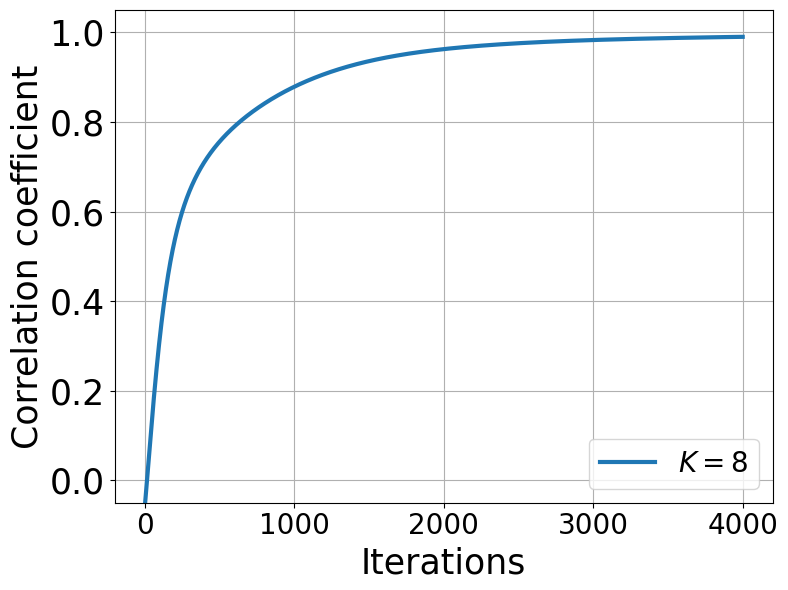



 For data_combine :
Only shows Wmm


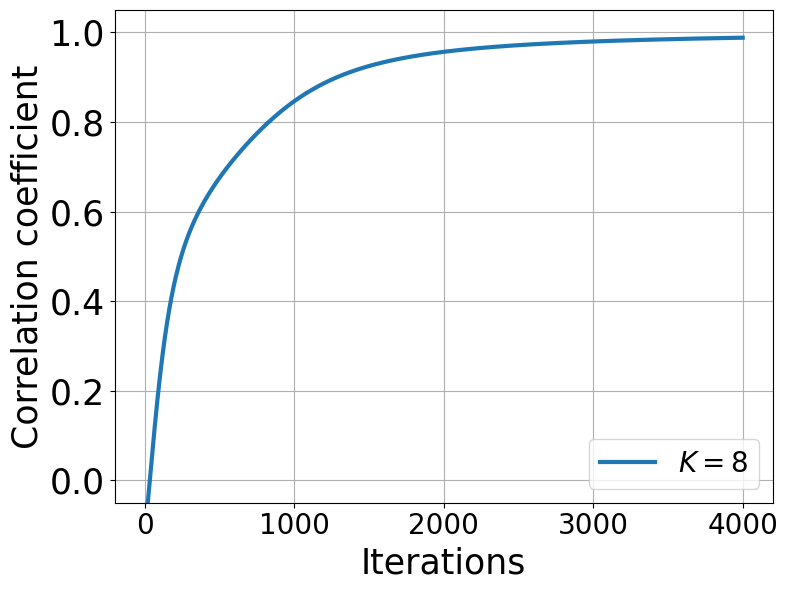

In [56]:
labels = [
    # r'$W(t)^{onetoken}$',
    r'$W(\tau)^{mm}$',
    r'$W(\tau)$',
]

for data in datasets:
    print('\n\n For', data, ':')
    show_corr(ITN, dlist, corr_list_values[data], wmm = True, labels = labels)

### Generate next token

In [57]:
# Randomly choose one epoch's data from all epochs for test
ei_test = random.choice(range(epochs))
ei_test

0

In [58]:
# Extract W^{svm}, W_1(\tau), W_2(\tau), W_cb(\tau) of the selected epoch
W_svm_test = torch.tensor(sol_cvx_list_epochs[ei_test]['data_topic_1'][0])

W_1_test = torch.tensor(last_W_epochs[ei_test]['data_topic_1'])
W_2_test = torch.tensor(last_W_epochs[ei_test]['data_topic_2'])
W_cb_test = torch.tensor(last_W_epochs[ei_test]['data_combine'])

In [59]:
y_hat_idx_svm, y_hat_svm, softmax_svm, XWz_n_svm = generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_svm_test)
y_hat_idx_W1, y_hat_W1, softmax_W1, XWz_n_W1= generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_1_test)
y_hat_idx_W2, y_hat_W2, softmax_W2, XWz_n_W2 = generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_2_test)
y_hat_idx_Wcb, y_hat_Wcb, softmax_Wcb, XWz_n_Wcb = generate_next_token(ei_test = ei_test, topic = 'data_topic_1', W_test = W_cb_test)

<ipython-input-38-fa3973bad719>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_i = torch.tensor(X_epochs[ei_test][topic][i])


### Compare the Similarity

In [60]:
# check different prediction from topic 1 and topic combination
diff_t1_cb = 0 # count # of diff next tokens
diff_seqs = [] # save the sequence ID in the input data
diff_seqs_last = set() # save the last token ID the difference comes from

for i in range(n):

    if y_hat_idx_W1[i] != y_hat_idx_Wcb[i]:
        diff_t1_cb+=1
        diff_seqs.append(i)
        print('==============================================================================')
        print("For", i, "sequence:")
        print("next token from W1:", y_hat_idx_W1[i])
        print("next token from W2:", y_hat_idx_W2[i])
        print("next token from Wcb", y_hat_idx_Wcb[i])
        seq = data_epochs[ei_test]['topic_1'][i]
        print("sequence:", seq)
        last_token = data_epochs[ei_test]['topic_1'][i][0][-1]
        diff_seqs_last.add(last_token)
        print("\n************** Topic 1 **************")
        print("scc_lst for the token", last_token, ":", scc_klst_epochs[ei_test]['data_topic_1'][last_token] )
        print("tpg for the last token", last_token, ":", updated_tpgs_epochs[ei_test]['topic_1'][last_token])
        print("softmax output:", softmax_W1[i])
        print("softmax input:", XWz_n_W1[i])
        print("\n************** Topic 2 **************")
        print("scc_lst for the token", last_token,  ":", scc_klst_epochs[ei_test]['data_topic_2'][last_token] )
        print("tpg for the last token", last_token, ":", updated_tpgs_epochs[ei_test]['topic_2'][last_token])
        print("softmax output:", softmax_W2[i])
        print("softmax input:", XWz_n_W2[i])
        print("\n************** Topic Combination **************")
        print("scc_lst for the token", last_token,  ":", scc_klst_epochs[ei_test]['data_combine'][last_token] )
        print("tpg for the last token", last_token, ":", updated_tpgs_epochs[ei_test]['combine'][last_token])
        print("softmax output:", softmax_Wcb[i])
        print("softmax input:", XWz_n_Wcb[i])
print("Number of different next tokens from Topic 1 and Combine:", diff_t1_cb, "out of", n)

For 18 sequence:
next token from W1: 3
next token from W2: 1
next token from Wcb 1
sequence: ([3, 1, 1, 3], 3)

************** Topic 1 **************
scc_lst for the token 3 : [0, 1, 2, 4, 5, 6, 3, 7]
tpg for the last token 3 : [(6, 3), (5, 1), (4, 1), (4, 6), (1, 3), (1, 6), (5, 4)]
softmax output: tensor([[0.2815],
        [0.2185],
        [0.2185],
        [0.2815]], dtype=torch.float64)
softmax input: tensor([[ 0.1626],
        [-0.0910],
        [-0.0910],
        [ 0.1626]], dtype=torch.float64)

************** Topic 2 **************
scc_lst for the token 3 : [6, 4, 0, 1, 2, 3, 5, 7]
tpg for the last token 3 : [(3, 0), (4, 6), (2, 3), (5, 1), (1, 0), (4, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 2)]
softmax output: tensor([[0.2257],
        [0.2743],
        [0.2743],
        [0.2257]], dtype=torch.float64)
softmax input: tensor([[-0.0693],
        [ 0.1260],
        [ 0.1260],
        [-0.0693]], dtype=torch.float64)

************** Topic Combination **************
scc_lst for th

### Check results

In [61]:
# Reproduce the TPG based on the last token from diff_seqs_last
input_1 = data_epochs[ei_test]['topic_1']
input_2 = data_epochs[ei_test]['topic_2']
input_combine = data_epochs[ei_test]['combine']
for item in diff_seqs_last:
  extract_input_1 = [seq for seq in input_1 if seq[0][-1] == item]
  extract_input_2 = [seq for seq in input_2 if seq[0][-1] == item]
  extract_input_combine = [seq for seq in input_combine if seq[0][-1] == item]
  print("\n================================================================\n")
  print(f"Seqences with the last token {item}:")
  print("extracted_input_topic_1:", extract_input_1)
  print("extracted_input_topic_2:", extract_input_2)
  print("extracted_input_topic_combine:", extract_input_combine)
  print("scc_topic_1:", scc_klst_epochs[ei_test]['data_topic_1'][item])
  print("scc_topic_2:", scc_klst_epochs[ei_test]['data_topic_2'][item])
  print("scc_topic_combine:", scc_klst_epochs[ei_test]['data_combine'][item])
  print("tpgs_topic_1:", updated_tpgs_epochs[ei_test]['topic_1'][item])
  print("tpgs_topic_2:", updated_tpgs_epochs[ei_test]['topic_2'][item])
  print("tpgs_topic_combine:", updated_tpgs_epochs[ei_test]['combine'][item])



Seqences with the last token 1:
extracted_input_topic_1: [([6, 6, 1, 1], 1), ([3, 3, 3, 1], 3), ([3, 3, 5, 1], 5), ([1, 2, 2, 1], 2), ([2, 2, 3, 1], 3), ([2, 2, 2, 1], 2), ([3, 3, 3, 1], 3), ([1, 1, 1, 1], 1), ([2, 2, 2, 1], 2), ([5, 3, 5, 1], 5), ([2, 3, 1, 1], 3), ([6, 6, 1, 1], 1), ([1, 5, 3, 1], 5), ([3, 2, 5, 1], 5), ([5, 5, 5, 1], 5)]
extracted_input_topic_2: [([7, 1, 7, 1], 7), ([5, 1, 1, 1], 1), ([1, 1, 1, 1], 1), ([7, 2, 7, 1], 2), ([1, 1, 7, 1], 7)]
extracted_input_topic_combine: [([7, 1, 7, 1], 7), ([3, 5, 1, 1], 1), ([1, 6, 5, 1], 5), ([1, 7, 7, 1], 7), ([5, 1, 1, 1], 1), ([1, 6, 5, 1], 5), ([1, 7, 1, 1], 7), ([3, 6, 1, 1], 1)]
scc_topic_1: [0, 2, 3, 4, 5, 6, 1, 7]
scc_topic_2: [0, 2, 4, 5, 6, 1, 7, 3]
scc_topic_combine: [0, 3, 4, 2, 5, 3, 1, 6]
tpgs_topic_1: [(6, 1), (2, 5), (3, 5), (1, 5), (1, 2), (1, 3), (2, 3)]
tpgs_topic_2: [(1, 2), (6, 5), (3, 6), (7, 2), (3, 1), (5, 1), (1, 7)]
tpgs_topic_combine: [(6, 1), (2, 5), (3, 5), (1, 5), (1, 2), (1, 3), (2, 3), (6, 5), (3,

In [52]:
endtime = time.time()
print(endtime - starttime)

7871.494847536087
